In [4]:
from pyspark.sql import SparkSession

In [5]:
!pip install pyspark

In [6]:
sp = SparkSession.builder\
    .appName("rent_predictions")\
    .getOrCreate() 

In [7]:
spp = sp.read.csv("House_Rent_Dataset.csv",header = True,inferSchema=True)

In [8]:
spp.show(5)

+----------+---+-----+----+---------------+-----------+--------------------+-------+-----------------+----------------+--------+----------------+
| Posted On|BHK| Rent|Size|          Floor|  Area Type|       Area Locality|   City|Furnishing Status|Tenant Preferred|Bathroom|Point of Contact|
+----------+---+-----+----+---------------+-----------+--------------------+-------+-----------------+----------------+--------+----------------+
|2022-05-18|  2|10000|1100|Ground out of 2| Super Area|              Bandel|Kolkata|      Unfurnished|Bachelors/Family|       2|   Contact Owner|
|2022-05-13|  2|20000| 800|     1 out of 3| Super Area|Phool Bagan, Kank...|Kolkata|   Semi-Furnished|Bachelors/Family|       1|   Contact Owner|
|2022-05-16|  2|17000|1000|     1 out of 3| Super Area|Salt Lake City Se...|Kolkata|   Semi-Furnished|Bachelors/Family|       1|   Contact Owner|
|2022-07-04|  2|10000| 800|     1 out of 2| Super Area|         Dumdum Park|Kolkata|      Unfurnished|Bachelors/Family|     

In [9]:
sph = spp.drop("Posted On")

In [10]:
sph.show(5)

+---+-----+----+---------------+-----------+--------------------+-------+-----------------+----------------+--------+----------------+
|BHK| Rent|Size|          Floor|  Area Type|       Area Locality|   City|Furnishing Status|Tenant Preferred|Bathroom|Point of Contact|
+---+-----+----+---------------+-----------+--------------------+-------+-----------------+----------------+--------+----------------+
|  2|10000|1100|Ground out of 2| Super Area|              Bandel|Kolkata|      Unfurnished|Bachelors/Family|       2|   Contact Owner|
|  2|20000| 800|     1 out of 3| Super Area|Phool Bagan, Kank...|Kolkata|   Semi-Furnished|Bachelors/Family|       1|   Contact Owner|
|  2|17000|1000|     1 out of 3| Super Area|Salt Lake City Se...|Kolkata|   Semi-Furnished|Bachelors/Family|       1|   Contact Owner|
|  2|10000| 800|     1 out of 2| Super Area|         Dumdum Park|Kolkata|      Unfurnished|Bachelors/Family|       1|   Contact Owner|
|  2| 7500| 850|     1 out of 2|Carpet Area|       Sout

In [11]:
sph.describe().show()

+-------+------------------+-----------------+-----------------+--------------------+----------+--------------------+---------+-----------------+----------------+-----------------+----------------+
|summary|               BHK|             Rent|             Size|               Floor| Area Type|       Area Locality|     City|Furnishing Status|Tenant Preferred|         Bathroom|Point of Contact|
+-------+------------------+-----------------+-----------------+--------------------+----------+--------------------+---------+-----------------+----------------+-----------------+----------------+
|  count|              4746|             4746|             4746|                4746|      4746|                4746|     4746|             4746|            4746|             4746|            4746|
|   mean|2.0838600927096502|34993.45132743363|967.4907290349768|  1.6666666666666667|      NULL|            352525.5|     NULL|             NULL|            NULL|1.965865992414665|            NULL|
| stddev|0

# Linear algothrim

In [12]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

In [13]:
encode = StringIndexer(inputCols=["Floor","Area Type","Area Locality","City","Furnishing Status","Tenant Preferred","Point of Contact"],outputCols=["Floor1","Area Type1","Area Locality1","City1","Furnishing Status1","Tenant Preferred1","Point of Contact1"])

In [14]:
sph = encode.fit(sph).transform(sph)
sph.show(5)

+---+-----+----+---------------+-----------+--------------------+-------+-----------------+----------------+--------+----------------+------+----------+--------------+-----+------------------+-----------------+-----------------+
|BHK| Rent|Size|          Floor|  Area Type|       Area Locality|   City|Furnishing Status|Tenant Preferred|Bathroom|Point of Contact|Floor1|Area Type1|Area Locality1|City1|Furnishing Status1|Tenant Preferred1|Point of Contact1|
+---+-----+----+---------------+-----------+--------------------+-------+-----------------+----------------+--------+----------------+------+----------+--------------+-----+------------------+-----------------+-----------------+
|  2|10000|1100|Ground out of 2| Super Area|              Bandel|Kolkata|      Unfurnished|Bachelors/Family|       2|   Contact Owner|   1.0|       0.0|         472.0|  5.0|               1.0|              0.0|              0.0|
|  2|20000| 800|     1 out of 3| Super Area|Phool Bagan, Kank...|Kolkata|   Semi-Fur

In [15]:
vec = VectorAssembler(inputCols=["Floor1","Area Type1","Area Locality1","City1","Furnishing Status1","Tenant Preferred1","Point of Contact1"],outputCol= "indepent_col")

In [16]:
sph = vec.transform(sph)
sph.show(5)

+---+-----+----+---------------+-----------+--------------------+-------+-----------------+----------------+--------+----------------+------+----------+--------------+-----+------------------+-----------------+-----------------+--------------------+
|BHK| Rent|Size|          Floor|  Area Type|       Area Locality|   City|Furnishing Status|Tenant Preferred|Bathroom|Point of Contact|Floor1|Area Type1|Area Locality1|City1|Furnishing Status1|Tenant Preferred1|Point of Contact1|        indepent_col|
+---+-----+----+---------------+-----------+--------------------+-------+-----------------+----------------+--------+----------------+------+----------+--------------+-----+------------------+-----------------+-----------------+--------------------+
|  2|10000|1100|Ground out of 2| Super Area|              Bandel|Kolkata|      Unfurnished|Bachelors/Family|       2|   Contact Owner|   1.0|       0.0|         472.0|  5.0|               1.0|              0.0|              0.0|[1.0,0.0,472.0,5....|


In [17]:
data = sph.select("indepent_col","Rent")
data.show(4)

+--------------------+-----+
|        indepent_col| Rent|
+--------------------+-----+
|[1.0,0.0,472.0,5....|10000|
|(7,[0,2,3],[4.0,6...|20000|
|(7,[0,2,3],[4.0,1...|17000|
|(7,[2,3,4],[516.0...|10000|
+--------------------+-----+
only showing top 4 rows



In [18]:
train,test = data.randomSplit([0.8,0.2])

In [19]:
model = LinearRegression(featuresCol="indepent_col",labelCol="Rent")
model = model.fit(train)

In [20]:
model.coefficients

DenseVector([146.1526, 5133.8031, 0.6821, -4796.3089, 419.7323, -874.6815, 38019.5563])

In [21]:
model.intercept

24516.02432928414

In [22]:
pred = model.evaluate(test)
pred.predictions.show()

+--------------------+------+------------------+
|        indepent_col|  Rent|        prediction|
+--------------------+------+------------------+
|(7,[0,1,2],[18.0,...| 24000| 33008.34393618788|
|(7,[0,1,2],[40.0,...| 28000| 35613.24835476591|
|(7,[0,1,2],[43.0,...| 61000| 36962.27050558006|
|(7,[0,1,2],[183.0...| 19500| 57510.26023058848|
|(7,[0,1,6],[18.0,...|120000| 70300.13083696444|
|(7,[0,1,6],[50.0,...|320000|  74977.0146666625|
|(7,[0,2],[3.0,134...| 30000| 25870.50304514267|
|(7,[0,2],[6.0,218...| 35000| 26881.90023383616|
|(7,[0,2],[14.0,11...| 24000| 26641.96326855101|
|(7,[0,2],[14.0,13...| 35000|  26654.9226105314|
|(7,[0,2],[17.0,21...| 65000| 28499.12803912252|
|(7,[0,2],[29.0,96...|  9400|29410.602246534007|
|(7,[0,2],[34.0,18...| 31000|30770.234466288464|
|(7,[0,2],[38.0,21...|  8000| 31523.31639074578|
|(7,[0,2],[92.0,17...| 32000| 38079.38148812008|
|(7,[0,2,3],[1.0,7...| 10000|15074.333694749377|
|(7,[0,2,3],[1.0,2...| 30000| 694.2739900065026|
|(7,[0,2,3],[1.0,2..

In [23]:
print("rmse",pred.rootMeanSquaredError)
print("meanAbsoluteError",pred.meanAbsoluteError)
print("meaanSqaurederror",pred.meanSquaredError)
print("r sqaure",pred.r2)

rmse 48640.272448621705
meanAbsoluteError 22576.55929452751
meaanSqaurederror 2365876103.8761477
r sqaure 0.2896255633313961


<Axes: >

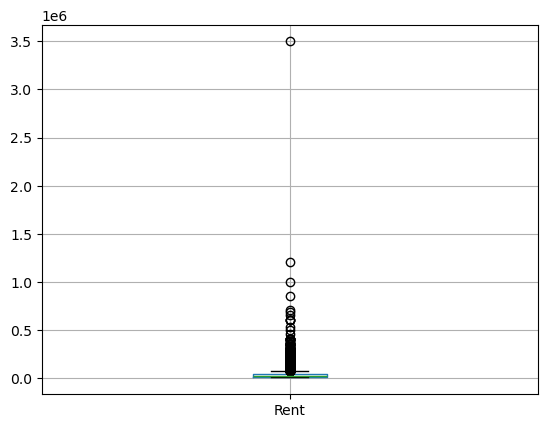

In [24]:
pd = sph.toPandas()
pd.boxplot("Rent")

In [25]:
pd.head()

,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Floor1,Area Type1,Area Locality1,City1,Furnishing Status1,Tenant Preferred1,Point of Contact1,indepent_col
0,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,1.0,0.0,472.0,5.0,1.0,0.0,0.0,"[1.0, 0.0, 472.0, 5.0, 1.0, 0.0, 0.0]"
1,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,4.0,0.0,671.0,5.0,0.0,0.0,0.0,"(4.0, 0.0, 671.0, 5.0, 0.0, 0.0, 0.0)"
2,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,4.0,0.0,13.0,5.0,0.0,0.0,0.0,"(4.0, 0.0, 13.0, 5.0, 0.0, 0.0, 0.0)"
3,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,0.0,0.0,516.0,5.0,1.0,0.0,0.0,"(0.0, 0.0, 516.0, 5.0, 1.0, 0.0, 0.0)"
4,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,0.0,1.0,1980.0,5.0,1.0,1.0,0.0,"[0.0, 1.0, 1980.0, 5.0, 1.0, 1.0, 0.0]"


In [26]:
pd.boxplot(column="Rent")

<Axes: >

In [27]:
import matplotlib.pyplot as plt

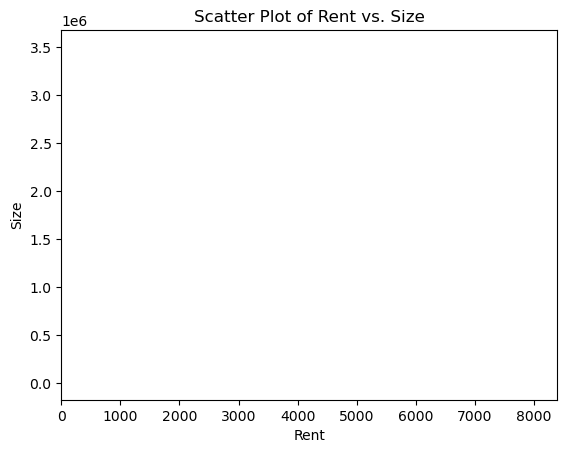

In [39]:
plt.barh(pd['Rent'], pd['Size'])

# Add labels and title
plt.xlabel('Rent')
plt.ylabel('Size')
plt.title('Scatter Plot of Rent vs. Size')

# Show the plot
plt.show()
